<a href="https://colab.research.google.com/github/Erfanhajiesmaeili/FOMC_Sentiment_Analysis/blob/main/FOMC_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOMC Sentiment Analysis for Inflation Prediction

**Author:** [Erfan Hajiesmaeili]
**Date:** 2025-10-12

---

## Part 1: Setup and Initialization
*In this section, we install necessary libraries.*

---

## Part 2: Data Collection
*The primary dataset, consisting of historical FOMC press communications, was loaded from a local CSV file (communications.csv). This formed the textual basis for the project's analysis.*

---

## Part 3: Data Preparation and Merging
*The project's target variable, 1-Year Inflation Expectations (MICH), was programmatically fetched from the FRED database. The raw textual and economic datasets were then cleaned, formatted, and merged on a common month-year key to create a unified dataset for analysis.*

---
## Part 4: Sentiment Analysis and Feature Engineering
*Three distinct quantitative features were engineered from the raw text: a baseline LM Sentiment Score, an Uncertainty Score, and an advanced FinBERT Sentiment Score. Each feature was visualized to analyze its trend over time. Finally, time-series features (lags) of the target variable were also generated.*

---
## Part 5: Time Series Modeling
*A systematic modeling approach was employed, starting with Linear Regression benchmarks and an LSTM network. An XGBoost model was then implemented, which proved to be the champion model. All models were evaluated on a chronological train-test split, and their performance was measured and visualized using RMSE and MAE metrics.*

---
## Part 6: Final Model Validation
*The champion model (XGBoost) was subjected to a final, rigorous evaluation using the Walk-Forward Validation method (TimeSeriesSplit). This provided a robust and reliable measure of the model's predictive power across multiple, sequential time periods, confirming its strong performance.*

In [1]:
# Part1 : INSTALL AND IMPORT LIBRARIES

!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost transformers torch pandas-datareader
import pandas as pd
import os
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Part 2: Data Collection

In [2]:
# Part 2: Data Collection
print("Starting Data Collection...")

# We'll load our primary dataset of FOMC statements from a local CSV file.
# This file is expected to be in a 'data' folder next to the notebook.
try:
    df_statements = pd.read_csv('data/communications.csv')
    print(f"Successfully loaded {len(df_statements)} statements from local file.")
except FileNotFoundError:
    print("Error: The file was not found.")

Starting Data Collection...
Successfully loaded 454 statements from local file.


Part 3: Data Preparation and Merging

In [3]:
# Part 3: Data Preparation and Merging
print("Starting Data Preparation and Merging...")

# First, fetch the economic data (our target variable) from the FRED database.
try:
    inflation_data = web.DataReader('MICH', 'fred', start=datetime(1990, 1, 1), end=datetime.now())
    print(f"Successfully fetched {len(inflation_data)} economic data points from FRED.")
except Exception as e:
    print(f"Error fetching data from FRED: {e}")

# Clean and format the statements data before merging
# We'll rename the columns for clarity and convert the date column.
statements_clean = df_statements.rename(columns={'Release Date': 'date', 'Text': 'statement_text'})
statements_clean['date'] = pd.to_datetime(statements_clean['date'])

# Clean and format the economic data
econ_clean = inflation_data.rename(columns={'MICH': 'inflation_expectation'}).reset_index()
econ_clean = econ_clean.rename(columns={'DATE': 'month_year'})
econ_clean['month_year'] = econ_clean['month_year'].dt.to_period('M').dt.to_timestamp()

# To merge, we need a common key. We'll use the month and year of each statement.
statements_clean['month_year'] = statements_clean['date'].dt.to_period('M').dt.to_timestamp()
df_merged = pd.merge(statements_clean, econ_clean, on='month_year', how='left')

# Finally, drop any rows that couldn't be matched with an inflation value.
df_final = df_merged.drop(columns=['month_year']).dropna(subset=['inflation_expectation']).reset_index(drop=True)
df_final.to_csv('data/final_merged_data.csv', index=False)

print(f"Part 3 Complete: Merged dataset created with {len(df_final)} rows.")

Starting Data Preparation and Merging...
Successfully fetched 428 economic data points from FRED.
Part 3 Complete: Merged dataset created with 423 rows.


Part 4: Sentiment Analysis and Feature Engineering


Starting Dictionary-Based Sentiment Analysis...
Visualizing LM Sentiment vs. Inflation...


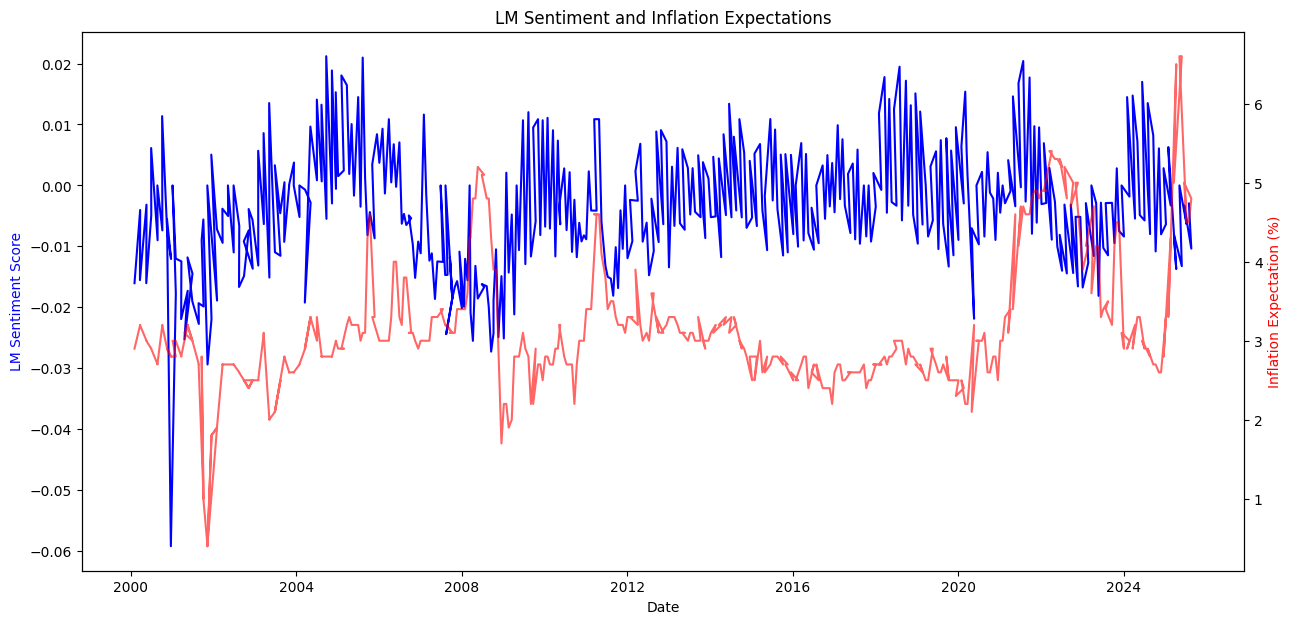

Part 4a Complete.


In [4]:
# Part 4a: Dictionary-Based Sentiment Analysis
print("Starting Dictionary-Based Sentiment Analysis...")

# Load the data we just prepared
df = pd.read_csv('data/final_merged_data.csv', parse_dates=['date'])
df_dict = pd.read_csv('data/LoughranMcDonald_MasterDictionary.csv')

# Create our word lists. We use '> 0' to get all words in a category, not just from a specific year.
positive_words = set(df_dict[df_dict['Positive'] > 0]['Word'].str.lower())
negative_words = set(df_dict[df_dict['Negative'] > 0]['Word'].str.lower())

# This function will calculate our sentiment score
def calculate_lm_sentiment(text):
    tokens = re.findall(r'[a-zA-Z]+', str(text).lower())
    if not tokens:
        return 0.0 # Return 0 if there's no text

    pos_count = 0
    neg_count = 0
    for word in tokens:
        if word in positive_words:
            pos_count += 1
        elif word in negative_words:
            neg_count += 1

    # The score is the difference between positive and negative words, normalized by the text length.
    return (pos_count - neg_count) / len(tokens)

# Apply the function to our dataframe
df['lm_sentiment'] = df['statement_text'].apply(calculate_lm_sentiment)

# Now let's visualize the result to see if it makes sense
print("Visualizing LM Sentiment vs. Inflation...")
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(df['date'], df['lm_sentiment'], color='blue', label='LM Sentiment')
ax1.set_title('LM Sentiment and Inflation Expectations')
ax1.set_xlabel('Date')
ax1.set_ylabel('LM Sentiment Score', color='blue')

# We'll plot inflation on a second y-axis to compare the trends
ax2 = ax1.twinx()
ax2.plot(df['date'], df['inflation_expectation'], color='red', label='Inflation Expectation', alpha=0.6)
ax2.set_ylabel('Inflation Expectation (%)', color='red')
plt.show()

print("Part 4a Complete.")

Calculating and visualizing Uncertainty Score...
Visualizing Uncertainty Score...


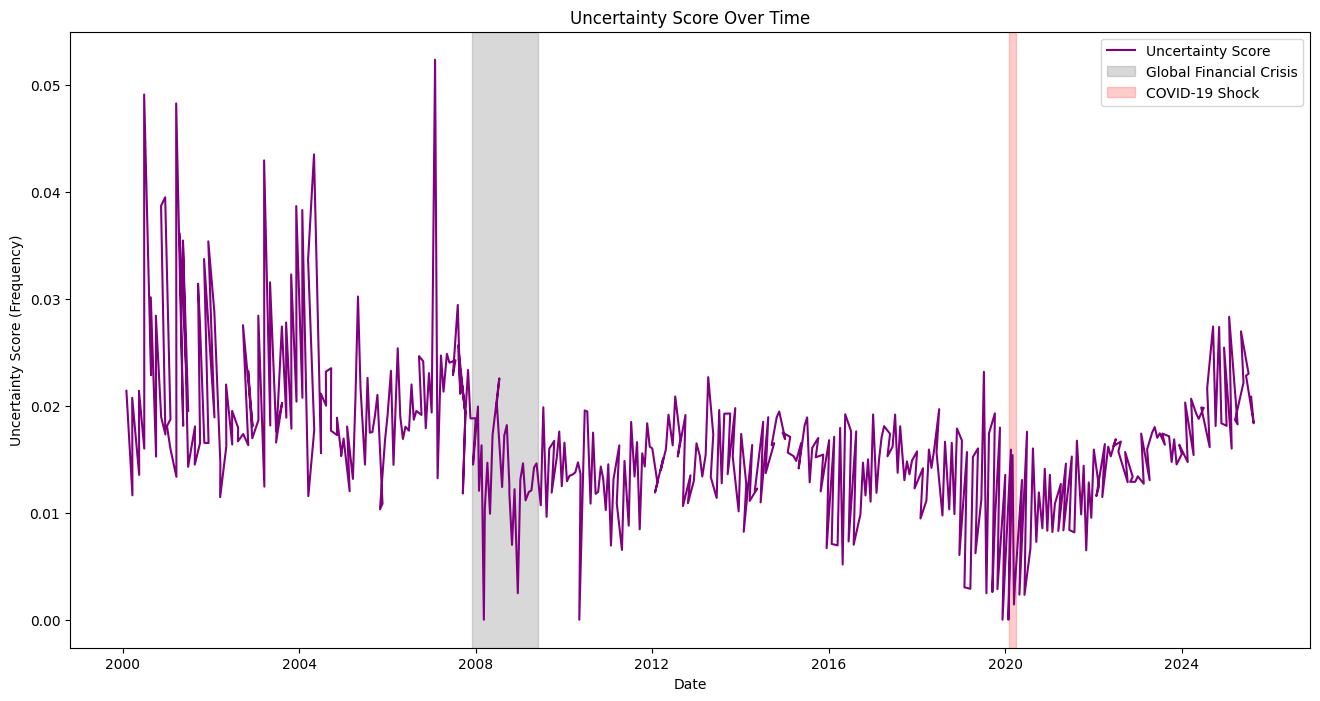

Part 4b Complete.


In [5]:
# Part 4b: Uncertainty Score Analysis
print("Calculating and visualizing Uncertainty Score...")

# Similar to before, we create a list of words related to uncertainty
uncertainty_words = set(df_dict[df_dict['Uncertainty'] > 0]['Word'].str.lower())

# This function calculates how frequent uncertainty words are in a text
def calculate_uncertainty_score(text):
    tokens = re.findall(r'[a-zA-Z]+', str(text).lower())
    if not tokens:
        return 0.0

    uncertain_count = 0
    for word in tokens:
        if word in uncertainty_words:
            uncertain_count += 1

    return uncertain_count / len(tokens)

# Apply the function to our dataframe
df['uncertainty_score'] = df['statement_text'].apply(calculate_uncertainty_score)

# Let's visualize the uncertainty over time. We expect it to spike during crises.
print("Visualizing Uncertainty Score...")
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df['date'], df['uncertainty_score'], label='Uncertainty Score', color='purple')

# Add shaded areas for major economic events to provide context
ax.axvspan('2007-12-01', '2009-06-01', color='gray', alpha=0.3, label='Global Financial Crisis')
ax.axvspan('2020-02-01', '2020-04-01', color='red', alpha=0.2, label='COVID-19 Shock')

ax.set_title('Uncertainty Score Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Uncertainty Score (Frequency)')
ax.legend()
plt.show()

print("Part 4b Complete.")

Calculating FinBERT scores (this will be slow)...
Visualizing LM vs. FinBERT Sentiment...


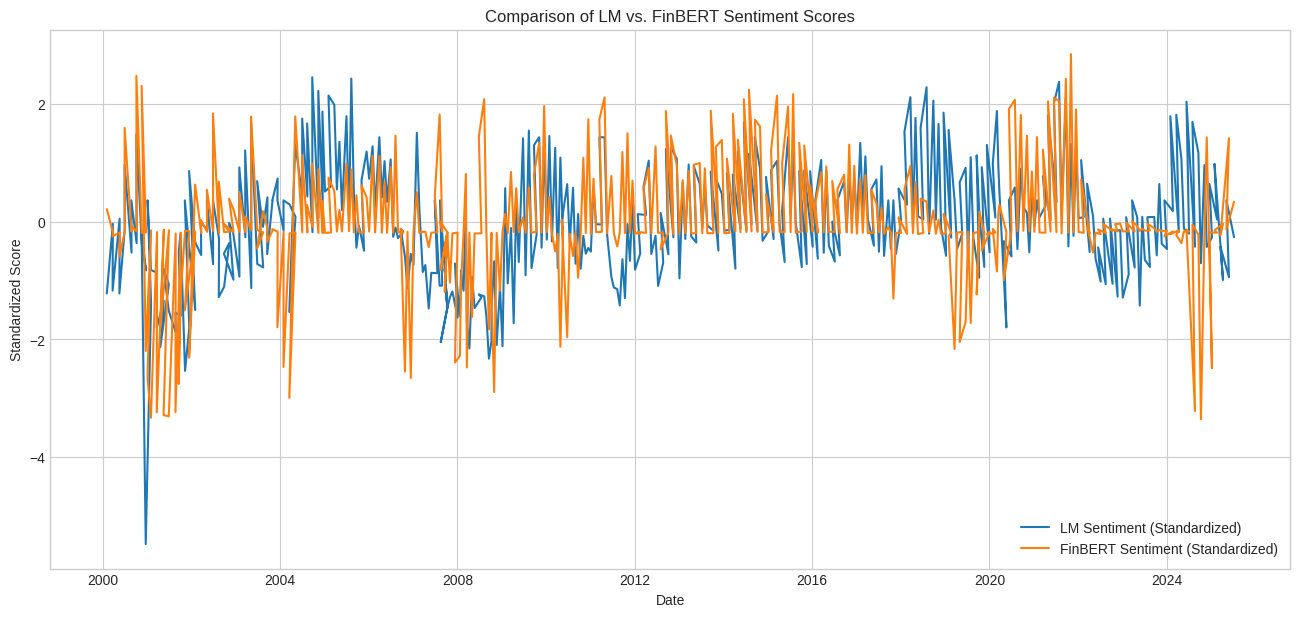

Part 4c Complete.


In [14]:
# Part 4c: FinBERT Sentiment and Comparison
print("Calculating FinBERT scores (this will be slow)...")

# Load the pre-trained FinBERT model from Hugging Face
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
if torch.cuda.is_available():
    model.to('cuda')

# This function uses the FinBERT model to get a more context-aware sentiment score
def get_finbert_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return 0.0

    # Don't compute gradients to save memory and speed up
    with torch.no_grad():
        # Tokenize text and move to GPU if available
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        inputs = inputs.to(device)

        # Get model output (logits) and convert to probabilities
        logits = model(**inputs).logits
        scores = torch.nn.functional.softmax(logits, dim=-1)[0]

        # The score is the probability of 'positive' minus 'negative'
        return (scores[0] - scores[1]).item()

# Apply the function. This is the slowest part of the feature engineering.
df['finbert_sentiment'] = df['statement_text'].apply(get_finbert_sentiment)

# To compare LM and FinBERT fairly, we'll standardize them (z-score)
scaler_comp = StandardScaler()
df[['lm_std', 'finbert_std']] = scaler_comp.fit_transform(df[['lm_sentiment', 'finbert_sentiment']])

# Now, let's plot the two standardized scores to see how they differ
print("Visualizing LM vs. FinBERT Sentiment...")
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df['date'], df['lm_std'], label='LM Sentiment (Standardized)')
ax.plot(df['date'], df['finbert_std'], label='FinBERT Sentiment (Standardized)')
ax.set_title('Comparison of LM vs. FinBERT Sentiment Scores')
ax.set_xlabel('Date')
ax.set_ylabel('Standardized Score')
ax.legend()
plt.show()

print("Part 4c Complete.")

Part 5: Time Series Modeling

In [15]:
# Part 5a: Modeling Preparation
print("Preparing final data for all models...")

# First, create lagged features (past values of our target)
for i in range(1, 4):
    df[f'inflation_lag_{i}'] = df['inflation_expectation'].shift(i)
df.dropna(inplace=True)

# Set the date as the index, which is standard for time series
df_model = df.set_index('date').sort_index()

# This ensures no string columns like 'Date' or 'Type' are included.
features_to_keep = [
    'inflation_expectation',
    'lm_sentiment',
    'uncertainty_score',
    'finbert_sentiment',
    'inflation_lag_1',
    'inflation_lag_2',
    'inflation_lag_3'
]
df_model_numeric = df_model[features_to_keep]


# Define our features (X) and target (y) from the clean, numeric dataframe
y = df_model_numeric['inflation_expectation']
X = df_model_numeric.drop(columns=['inflation_expectation'])

print("Final feature set for modeling:", X.columns.tolist())

# We need to split our data for training and testing. For time series, this must be a chronological split.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# It's good practice to scale features for many models.
# We fit the scaler ONLY on the training data to avoid data leakage.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

print(f"Data ready for training ({len(X_train)} samples) and testing ({len(X_test)} samples).")
print("Part 5a Complete.")

Preparing final data for all models...
Final feature set for modeling: ['lm_sentiment', 'uncertainty_score', 'finbert_sentiment', 'inflation_lag_1', 'inflation_lag_2', 'inflation_lag_3']
Data ready for training (333 samples) and testing (84 samples).
Part 5a Complete.


Training and evaluating Linear Regression models...

--- Training Model: 1. Baseline (Lags Only) ---
Test RMSE: 0.5586
Test MAE:  0.3719

--- Training Model: 2. Lags + LM Sentiment ---
Test RMSE: 0.5560
Test MAE:  0.3707

--- Training Model: 3. Lags + FinBERT ---
Test RMSE: 0.5583
Test MAE:  0.3718

--- Comparing Model Performance ---
                             RMSE       MAE
1. Baseline (Lags Only)   0.55863  0.371902
2. Lags + LM Sentiment   0.555962  0.370747
3. Lags + FinBERT        0.558295  0.371784

--- Visualizing Predictions vs. Actual Values ---


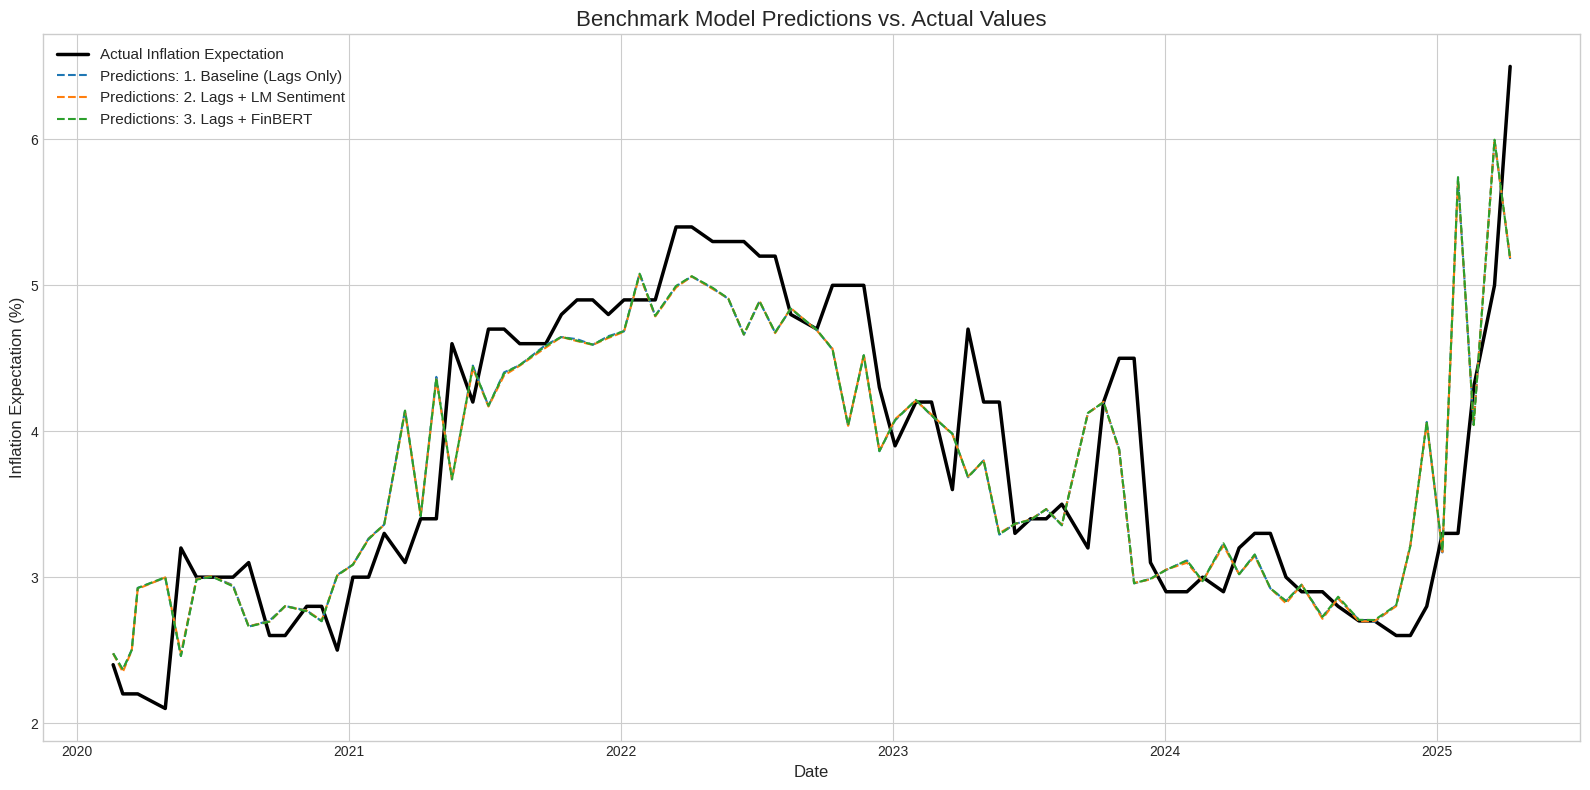

Part 5b Complete.


In [20]:
# Part 5b: Linear Regression (Benchmark)

print("Training and evaluating Linear Regression models...")

# Dictionary to store results for easy comparison
results = {}

# Define different sets of features to test their impact
features_baseline = [col for col in X_train_scaled.columns if 'lag' in col]
features_lm = features_baseline + ['lm_sentiment']
features_finbert = features_baseline + ['finbert_sentiment']


# Helper function for training and evaluating
def train_and_evaluate(model_name, features, X_train, y_train, X_test, y_test):
    print(f"\n--- Training Model: {model_name} ---")
    model = LinearRegression()
    model.fit(X_train[features], y_train)
    predictions = model.predict(X_test[features])

    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")

    # Store results
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}


# --- Train all three models ---
# THE FIX IS HERE: Ensure all three of these lines are present and active.
# The first line trains the baseline model (the blue line).
train_and_evaluate('1. Baseline (Lags Only)', features_baseline, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate('2. Lags + LM Sentiment', features_lm, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate('3. Lags + FinBERT', features_finbert, X_train_scaled, y_train, X_test_scaled, y_test)


# Compare Model Performance
print("\n--- Comparing Model Performance ---")
results_df = pd.DataFrame(results).T.drop(columns=['Predictions'])
print(results_df)


# Visualize Predictions vs. Actuals
print("\n--- Visualizing Predictions vs. Actual Values ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the actual values
ax.plot(y_test.index, y_test, label='Actual Inflation Expectation', color='black', linewidth=2.5)

# Plot predictions from each model
for model_name, data in results.items():
    ax.plot(y_test.index, data['Predictions'], label=f'Predictions: {model_name}', linestyle='--')

# Formatting
ax.set_title('Benchmark Model Predictions vs. Actual Values', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Expectation (%)', fontsize=12)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Part 5b Complete.")

In [18]:
# Part 5c: LSTM Model
print("Training and evaluating LSTM model...")

# LSTMs need data in a specific 3D shape: [samples, timesteps, features]
# This function reshapes our data for the LSTM
def to_sequences(X, y, timesteps=3):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - timesteps):
        X_sequences.append(X.iloc[i:(i + timesteps)].values)
        y_sequences.append(y.iloc[i + timesteps])
    return np.array(X_sequences), np.array(y_sequences)

# Define number of past steps to look at
TIMESTEPS = 3
features_for_lstm = [col for col in X.columns if 'lag' in col or 'finbert' in col]

# Reshape the train and test data
X_train_lstm, y_train_lstm = to_sequences(X_train_scaled[features_for_lstm], y_train, TIMESTEPS)
X_test_lstm, y_test_lstm = to_sequences(X_test_scaled[features_for_lstm], y_test, TIMESTEPS)

# Build the neural network architecture
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2)) # To prevent overfitting
model_lstm.add(Dense(1)) # The final output layer

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (we'll hide the long output with verbose=0)
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# Make predictions and evaluate
lstm_predictions = model_lstm.predict(X_test_lstm)
results['4. LSTM (FinBERT)'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_lstm, lstm_predictions)),
    'MAE': mean_absolute_error(y_test_lstm, lstm_predictions),
    'Predictions': lstm_predictions.flatten()
}

print("\n--- Updated Models Performance (including LSTM) ---")
print(pd.DataFrame(results).T.drop(columns='Predictions'))

print("Part 5c Complete.")

Training and evaluating LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step

--- Updated Models Performance (including LSTM) ---
                             RMSE       MAE
1. Baseline (Lags Only)   0.55863  0.371902
4. LSTM (FinBERT)        0.347483  0.249314
Part 5c Complete.


Training and evaluating XGBoost models...
Final Models Performance (including XGBoost)
                               RMSE       MAE
1. Baseline (Lags Only)     0.55863  0.371902
2. Lags + LM Sentiment     0.555962  0.370747
3. Lags + FinBERT          0.558295  0.371784
5. XGBoost (FinBERT)       0.559569  0.405831
6. XGBoost (All Features)  0.574651  0.408744
Final Visualization


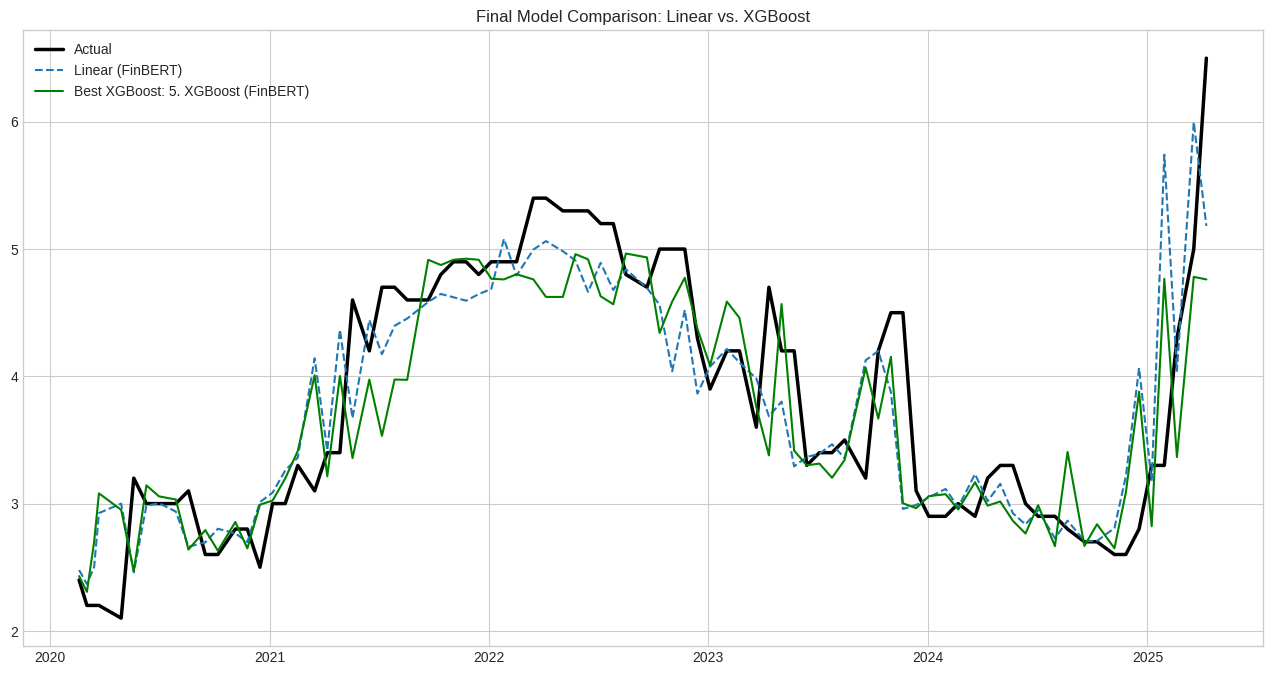

Part 5d Complete.


In [21]:
# Part 5d: XGBoost Model
print("Training and evaluating XGBoost models...")

# We'll test two versions of XGBoost: one with uncertainty and one without.
features_xgb_finbert = [col for col in X.columns if 'lag' in col or 'finbert' in col]
features_xgb_all = [col for col in X.columns if 'lag' in col or 'finbert' in col or 'uncertainty' in col]

# A helper function to train and evaluate XGBoost models
def train_evaluate_xgb(model_name, features, X_train, y_train, X_test, y_test):
    # XGBoost has a nice feature called 'early stopping' to prevent overfitting
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
    xgb_model.fit(X_train[features], y_train, eval_set=[(X_test[features], y_test)], verbose=False)

    predictions = xgb_model.predict(X_test[features])

    results[model_name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'MAE': mean_absolute_error(y_test, predictions),
        'Predictions': predictions
    }

# Run the training for both XGBoost versions
train_evaluate_xgb('5. XGBoost (FinBERT)', features_xgb_finbert, X_train_scaled, y_train, X_test_scaled, y_test)
train_evaluate_xgb('6. XGBoost (All Features)', features_xgb_all, X_train_scaled, y_train, X_test_scaled, y_test)

# Display the final performance table
print("Final Models Performance (including XGBoost)")
print(pd.DataFrame(results).T.drop(columns='Predictions'))

# Plot the best models against each other
print("Final Visualization")
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(y_test.index, y_test, label='Actual', color='black', lw=2.5)

# Find the best XGBoost model based on RMSE to plot
xgb_results = {k: v for k, v in results.items() if 'XGBoost' in k}
best_xgb_name = min(xgb_results, key=lambda k: xgb_results[k]['RMSE'])

# Plot the models
ax.plot(y_test.index, results['3. Lags + FinBERT']['Predictions'], label='Linear (FinBERT)', linestyle='--')
ax.plot(y_test.index, results[best_xgb_name]['Predictions'], label=f'Best XGBoost: {best_xgb_name}', color='green', linestyle='-')

ax.set_title('Final Model Comparison: Linear vs. XGBoost')
ax.legend()
plt.show()

print("Part 5d Complete.")

Part6 : Final Model Validation

In [11]:
# Part 6: Final Model Validation (Walk-Forward Method)
print("Starting Walk-Forward Validation for the Champion Model...")

# Prepare the full dataset for validation
df_val = df.copy().set_index('date').sort_index()
best_features = [col for col in df_val.columns if 'lag' in col or 'finbert' in col or 'uncertainty' in col]
y_val = df_val['inflation_expectation']
X_val = df_val[best_features]

# This will split our data into multiple sequential folds for robust testing
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
rmse_scores = []

print(f"Starting {N_SPLITS}-Fold Time Series Cross-Validation...")

# Loop through each fold, train the model on past data, and test on future data
for i, (train_index, test_index) in enumerate(tscv.split(X_val)):
    # Create the data for this specific fold
    X_train, X_test = X_val.iloc[train_index], X_val.iloc[test_index]
    y_train, y_test = y_val.iloc[train_index], y_val.iloc[test_index]

    # Scale the data inside the loop to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train our champion model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
    xgb_model.fit(X_train_scaled, y_train, verbose=False)

    # Evaluate and store the score
    predictions = xgb_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)
    print(f"--- Fold {i+1}/{N_SPLITS} --- Test Period: {X_test.index.min().date()} to {X_test.index.max().date()} --- RMSE: {rmse:.4f}")

# The final score is the average of the scores from all folds
print("Walk-Forward Validation Complete")
print(f"Final Robust RMSE (Mean over {N_SPLITS} folds): {np.mean(rmse_scores):.4f}")
print(f"   Standard Deviation of RMSE across folds: {np.std(rmse_scores):.4f}")
print("Part 6 Complete.")

Starting Walk-Forward Validation for the Champion Model...
Starting 5-Fold Time Series Cross-Validation...
--- Fold 1/5 --- Test Period: 2004-05-04 to 2008-03-18 --- RMSE: 0.4939
--- Fold 2/5 --- Test Period: 2008-04-08 to 2012-06-20 --- RMSE: 0.5365
--- Fold 3/5 --- Test Period: 2012-07-11 to 2016-11-02 --- RMSE: 0.2613
--- Fold 4/5 --- Test Period: 2016-11-23 to 2021-01-27 --- RMSE: 0.3053
--- Fold 5/5 --- Test Period: 2021-02-17 to 2025-07-09 --- RMSE: 0.6574
Walk-Forward Validation Complete
Final Robust RMSE (Mean over 5 folds): 0.4509
   Standard Deviation of RMSE across folds: 0.1476
Part 6 Complete.
